In [6]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

%matplotlib inline

DATA_DIR='/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need'
train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels
     

# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0


# Reduce dataset size
n_train = 50000
n_test = 30000

train_images = images[:]
train_labels = labels[:]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']
Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
import numpy as np

# ----------------- Data Augmentation -----------------
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# ----------------- Preprocess images -----------------
def prepare_for_vgg(images):
    # Resize to (224,224) and convert grayscale to RGB
    resized = np.array([resize(img, (224,224)).numpy() for img in images])
    if resized.shape[-1] == 1:  # grayscale to RGB
        resized = np.repeat(resized, 3, axis=-1)
    return resized

train_images_vgg = prepare_for_vgg(train_images)
test_images_vgg = prepare_for_vgg(test_images)

print("Train shape:", train_images_vgg.shape)
print("Test shape:", test_images_vgg.shape)

# ----------------- Callbacks -----------------
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    verbose=1,
    factor=0.1,
    min_lr=1e-5
)

# ----------------- Build VGG16 Model -----------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze VGG16 backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(EMOTIONS), activation='softmax')  # match number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ----------------- Training -----------------
batch_size = 32
epochs = 70  # transfer learning usually converges faster

history = model.fit(
    datagen.flow(train_images_vgg, train_labels_categorical, batch_size=batch_size),
    validation_data=(test_images_vgg, test_labels_categorical),
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

Train shape: (1700, 224, 224, 3)
Test shape: (1700, 224, 224, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,110,985 (57.64 MB)

 Trainable params: 396,297 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 588ms/step - accuracy: 0.1933 - loss: 2.1086 - val_accuracy: 0.2465 - val_loss: 1.9516 - learning_rate: 0.0010
Epoch 2/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.2505 - loss: 1.9550 - val_accuracy: 0.2700 - val_loss: 1.8898 - learning_rate: 0.0010
Epoch 3/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.2581 - loss: 1.9158 - val_accuracy: 0.2882 - val_loss: 1.8431 - learning_rate: 0.0010
Epoch 4/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.3106 - loss: 1.8372 - val_accuracy: 0.3047 - val_loss: 1.7973 - learning_rate: 0.0010
Epoch 5/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.2859 - loss: 1.8379 - val_accuracy: 0.3276 - val_loss: 1.7905 - learning_rate: 0.0010
Epoch 6/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.2922 - loss: 1.8337 - val_accuracy: 0.3429 - val_loss: 1.7348 - learning_rate: 0.0010
Epoch 7/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.3458 - loss: 1.

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step

Classification Report:

              precision    recall  f1-score   support

       Happy       0.47      0.51      0.49       297
         Sad       0.41      0.25      0.31        68
       Angry       0.53      0.10      0.17        98
   Surprised       0.38      0.60      0.47       144
     Neutral       0.70      0.70      0.70       407
   Disgusted       0.50      0.26      0.34       136
        Fear       0.45      0.58      0.51       298
      Sleepy       0.83      0.45      0.59        33
    Contempt       0.58      0.57      0.57       219

    accuracy                           0.53      1700
   macro avg       0.54      0.45      0.46      1700
weighted avg       0.54      0.53      0.52      1700



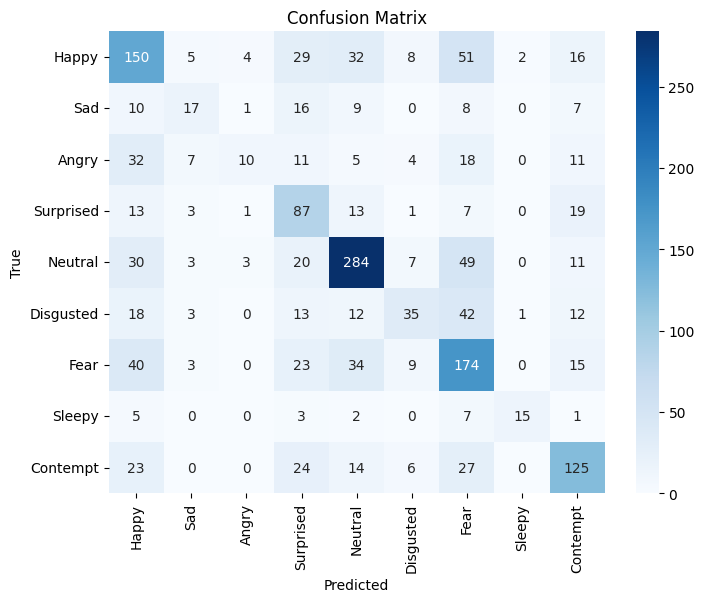

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------- Predictions -----------------
y_pred_probs = model.predict(test_images_vgg)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

# ----------------- Classification Report -----------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

# ----------------- Confusion Matrix -----------------
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()